# KNN Modelo


In [98]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [99]:
# Devuelve set de datos en un dataframe
def getDataTrain():
  return pd.read_csv("https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv&gid=2054774482")  

In [100]:
# Devuelve set de datos para predecir en un dataframe
def getDataValidation():
  return pd.read_csv("https://docs.google.com/spreadsheets/d/1ObsojtXfzvwicsFieGINPx500oGbUoaVTERTc69pzxE/export?format=csv&gid=972751642")  

In [101]:
# Devuelve el archivo de salida con las predicciones
def getResult(predictions_final, file_name):
  pd_predictions_final = pd.DataFrame(columns=["id", "tiene_alto_valor_adquisitivo"])
  pd_predictions_final.tiene_alto_valor_adquisitivo = predictions_final
  pd_predictions_final['id'] = pd_predictions_final.index + 1
  pd_predictions_final.set_index('id', inplace=True)
  pd_predictions_final.to_csv(file_name)

# Entrenamiento

In [102]:
def featureEngineering(df):
    df_clean = df.copy()

    df_clean["educacion_alcanzada"].replace({"preescolar" : 1, "1-4_grado": 2, "5-6_grado": 3, "7-8_grado" : 4, "9_grado" : 5, "1_anio" : 6, "2_anio" : 7, "3_anio" : 8, "4_anio" : 9, "5_anio" : 10, "universidad_1_anio" : 11, 
      "universidad_2_anio" : 12, "universidad_3_anio" : 13, "universidad_4_anio" : 14, "universiada_5_anio" : 15, "universiada_6_anio" : 16}, inplace = True)
    
    df_clean.rol_familiar_registrado.replace(to_replace=["casada"], value=["casado"], inplace=True)
    df_clean["opera_en_bolsa"] = df_clean["ganancia_perdida_declarada_bolsa_argentina"].apply(lambda x: 1 if x != 0 else 0)

    # Tratamiento de NaN
    df_clean.fillna('NaN', inplace=True)

    # Conversion de variables
    ordinalEncoder = OrdinalEncoder(dtype='int')
    columns_to_encode = ['barrio', 'categoria_de_trabajo', 'estado_marital', 'genero', 'religion', 'rol_familiar_registrado', 'trabajo']
    try:
      df_clean[['barrio_encoded', 'categoria_de_trabajo_encoded', 'estado_marital_encoded', 'genero_encoded', 'religion_encoded', 'rol_familiar_registrado_encoded', 'trabajo_encoded']] \
        = ordinalEncoder.fit_transform(df_clean[columns_to_encode].astype(str))
    except Exception as exception:
      print(f'Error en ordinal encoder: {exception}')

    # Elimino columnas
    df_clean.drop(columns = ['barrio', 'ganancia_perdida_declarada_bolsa_argentina', 'categoria_de_trabajo', 'estado_marital', 'genero', 'religion', 'rol_familiar_registrado', 'trabajo'], inplace = True)
    
    return df_clean

In [103]:
# Divido el set en entrenamiento y validacion
dfTrain = getDataTrain()
dfTrain_feature_engineering = featureEngineering(dfTrain)
X = dfTrain_feature_engineering.drop(columns = 'tiene_alto_valor_adquisitivo')
y = dfTrain_feature_engineering.tiene_alto_valor_adquisitivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [104]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Metricas

# Accuracy

In [105]:
accuracy_score(y_test, y_pred)

0.809765085214187

# Precision

In [106]:
precision_score(y_test, y_pred)

0.6322081575246132

# Recall

In [107]:
recall_score(y_test, y_pred, pos_label=0)

0.8932217231523071

# F1 Score

In [108]:
f1_score(y_test, y_pred)

0.5920316101415871

# Matriz de confusion

In [109]:
confusion_matrix(y_test, y_pred)

array([[4375,  523],
       [ 716,  899]])

# AUC-ROC

In [110]:
def plot_roc(_fpr, _tpr, x):
    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(_fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.scatter(_fpr, x)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

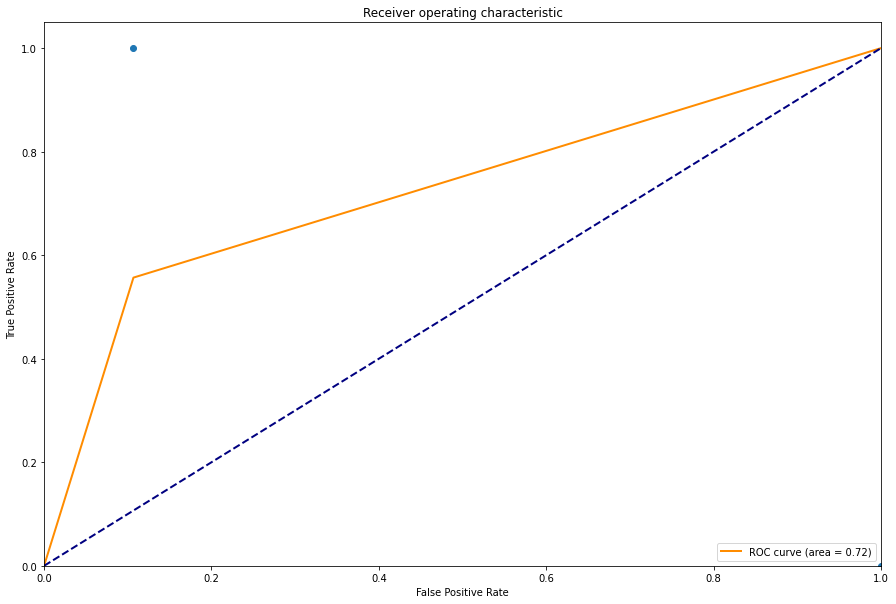

0.7249390349507665

In [111]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_test, y_pred))

# Prediccion

In [112]:
# Obtengo el set para predecir
dfObjetivo = getDataValidation()

# Elimino columnas "representatividad_poblacional" y "id"
dfObjetivo.drop(columns = ['representatividad_poblacional', 'id'], inplace = True)

# Aplico feature engineering
dfObjetivo_feature_engineering = featureEngineering(dfObjetivo)

predicciones = knn.predict(dfObjetivo_feature_engineering)
predicciones

array([0, 0, 1, ..., 1, 1, 1])

In [113]:
getResult(predicciones, 'pd_predictions_final_knn.csv')